# LSTM: The basics

In this notebook, we will learn the basics of a Long Short Term Memory (LSTM) based on [Keras](https://keras.io/), a high-level API for building and training deep learning models, running on top of [TensorFlow](https://www.tensorflow.org/), an open source platform for machine learning. 

We will build a few examples of an LSTM

* First we will build a basic LSTM to predict a stock price in the future. The data is provided in your training environment - but in future you can also access it in [this github repo](https://github.com/mwitiderrick/stockprice).
* We will then build some more complex LSTM structures, which take multiple datasources as input and also stacck up the LSTM layers within the network.

### Contents

1. [Converting and preparing data](#convert_data)
2. [A simple uni-variate LSTM](#simple_lstm)
3. [A multi-variate LSTM](#multi_variate)

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

plt.style.use('ggplot')

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


<a id='convert_data'></a>
## Converting data to sequence structure


One of the critical features of $RNNs$ and $LSTMs$ is that they work on sequences of data. In the lecture notes we saw that the network takes input at a time $t$ and the hiden layer state from $t-1$ and produces an output:

<img src="images/lstms-1.png" alt="lstms-1" width="500"/>

Howevere we may also want to include measured data from further back in time to help with remembering; so we could want input data from $t-1 \cdots t-n$. We might also have more than one channel of input data, this is called the  **window** of the data. Imagine for example we were predicting stock prices, we could have the histtory of that stock, but we might also want to know the central bank interest rate, or the strnght of one currance relative to another, in this case we have a **multi-variate** problem. So our input data looks more like:

<img src="images/lstms-2.png" alt="lstms-2" width="500"/>


Finally, we might also want to make our $LSTM$ predict more than just one step forward, so we will want to be able to have multiple steps in the output.

We write a function to convert dataframe series into data that is suitable for $LSTM$ training.

This function is quite flexible and can be useful in many scenarios, so it is one that you might like to reuse in future if you are training time series models.

As input we pass the data as a list or `numpy` array. We then also specify how far back in time we wish to look for each prediction `n_in`, so `n_in = 1` means we take just $t$ as input, `n_in=2` means we take $t, t-1$ as input and so on. We specify how far into the future we wish to predict, with the `n_out` variable. `n_out=1` means we predict for $t$, `n_out=2` means we predict for $t, t+1$ and so on.

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    The function automatically checks if we are dealing with a univariate or a multi-variate problem, by  
    checing the shape and type of `data`.
    Adapted from: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    Arguments:
       data: Sequence of observations as a list or NumPy array.
       n_in: Number of lag observations as input (X).
       n_out: Number of observations as output (y).
       dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
       Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<a id='simple_lstm'></a>

## A simple LSTM

### Importing and treating the data

We first read in our data and inspect it using `pandas`.

The next step is to normalise our data - we use the `MinMaxScaler` from `scikit-learn` to do this.

For an $LSTM$ we then want to pass our data to the network in chunks of time. This is so that the prediction at time $t$ draws on the input data from time $t-n$ all the way to $t$ where $n$ is the size of the chunk or "window" of time that we use. This is easy to achieve with a simple `for` loop, but it is a slightly different step in pre-processing that is required for $LSTMs$ or time-series problems compared to other ML tasks. 

In [5]:
# Importing the training set
dataset_train = pd.read_csv(data_path + 'lstm-data/data-train-lstm.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [6]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


We are only interested in predicing the `Open` price. So we can drop all other columns.

We then want to convert the data to a numpy array of type `float32`. 

Next we will transform the data to be in a range $0-1$, using the `MinMaxScaler`.

In [7]:
dataset_train.drop(dataset_train.columns[[0, 2, 3, 4, 5, 6, 7]], axis=1, inplace=True)
values = dataset_train.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### Converting to $LSTM$ structure data

We now want to convert the data to a strucuture that can be fed to the $LSTM$. To do this we use our `series_to_supervised` function. In this case we want to look back 80 steps and project forward one step. How would you do this?

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# frame as supervised learning
reframed = series_to_supervised(scaled, 80, 1)
print(reframed.head())
```
    
</p>
</details>

In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 80, 1)
print(reframed.head())

    var1(t-80)  var1(t-79)  var1(t-78)  var1(t-77)  var1(t-76)  var1(t-75)  \
80    0.620235    0.622263    0.644363    0.617194    0.618208    0.624088   
81    0.622263    0.644363    0.617194    0.618208    0.624088    0.627940   
82    0.644363    0.617194    0.618208    0.624088    0.627940    0.635847   
83    0.617194    0.618208    0.624088    0.627940    0.635847    0.616585   
84    0.618208    0.624088    0.627940    0.635847    0.616585    0.577251   

    var1(t-74)  var1(t-73)  var1(t-72)  var1(t-71)  ...  var1(t-9)  var1(t-8)  \
80    0.627940    0.635847    0.616585    0.577251  ...   0.803122   0.765207   
81    0.635847    0.616585    0.577251    0.548459  ...   0.765207   0.753852   
82    0.616585    0.577251    0.548459    0.573398  ...   0.753852   0.736618   
83    0.577251    0.548459    0.573398    0.573398  ...   0.736618   0.748175   
84    0.548459    0.573398    0.573398    0.567315  ...   0.748175   0.740470   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-

### Convert to numpy arrays

Again we want to convret from the `pandas` dataframe to a numpy array. We will also plot the data to have a look .

Text(0, 0.5, 'Normalised price')

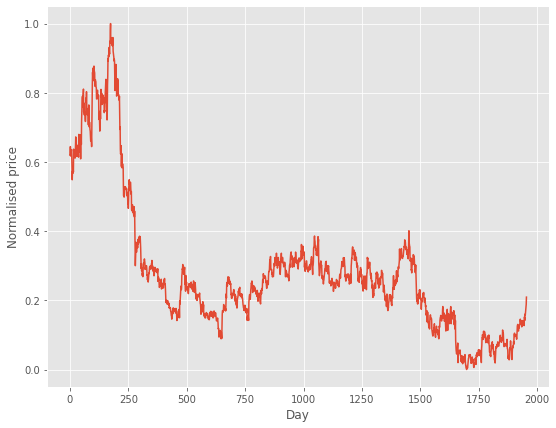

In [9]:
# Convert the dataframe to numpy arrays
values = reframed.values
X_train = values[:, :-1]
y_train = values[:, -1:]
X_train = np.expand_dims(X_train, axis=2)
y_train = np.squeeze(y_train)
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
plt.plot(X_train[:, 0, 0])
plt.xlabel('Day')
plt.ylabel('Normalised price')

### Building the network
<a id='build_lstm'></a>

Note that as before we start off from a `Sequential` type model in `Keras`.

The $LSTM$ layers are already coded in `Keras` so we do not need to worry about writing the complicated structure. We just need to consider a few hyper-parametes we want to set,

* Number of LSTM layers - we can stack LSTM layers in this case we will start with 2 stacked LSTMs
* units - this is the dimensionality of the hidden state and memory cell of the LSTM
* return_sequences - should we return the full output sequence or just the final value in the sequence. Generally, if the LSTM layer is feeding to another layer in the network, this would be `True` if the LSTM layer is the final layer then this is `False`, note default is `False`  

In the network strucure below, how would you add the second (final) $LSTM$ layer?

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))
```
    
</p>
</details>

In [10]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

##########
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))
##########

# Adding the output layer
regressor.add(Dense(units = 1))

### Compile the network

As ususal we need to compile the network, choosing an optimiser and a loss function.

We use `adam` as our optimiser and `mean_squared_error` as our loss.

In [11]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Train the network

In [12]:
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 128)

Epoch 1/30
16/16 [==============================] - 1s 83ms/step - loss: 0.0145
Epoch 2/30
16/16 [==============================] - 1s 92ms/step - loss: 0.0021
Epoch 3/30
16/16 [==============================] - 1s 84ms/step - loss: 0.0013
Epoch 4/30
16/16 [==============================] - 1s 82ms/step - loss: 0.0011
Epoch 5/30
16/16 [==============================] - 1s 93ms/step - loss: 0.0010
Epoch 6/30
16/16 [==============================] - 1s 84ms/step - loss: 9.7769e-04
Epoch 7/30
16/16 [==============================] - 1s 66ms/step - loss: 9.5482e-04
Epoch 8/30
16/16 [==============================] - 1s 65ms/step - loss: 9.6850e-04
Epoch 9/30
16/16 [==============================] - 1s 72ms/step - loss: 8.8895e-04
Epoch 10/30
16/16 [==============================] - 1s 68ms/step - loss: 8.8702e-04
Epoch 11/30
16/16 [==============================] - 1s 68ms/step - loss: 8.5472e-04
Epoch 12/30
16/16 [==============================] - 1s 70ms/step - loss: 8.2239e-04
Epoch 13/

Text(0, 0.5, 'mae')

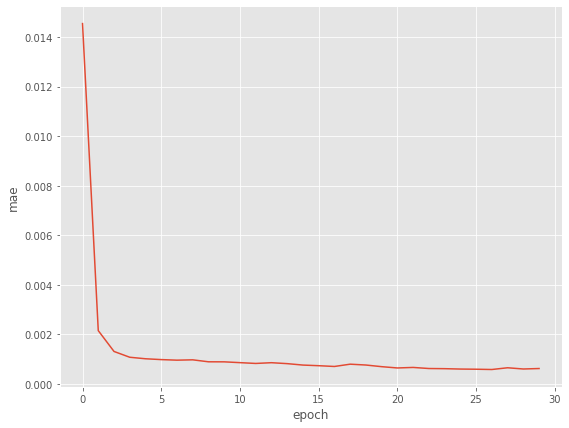

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('mae')

### Making predictions with our model

We now use model that we just built to predict on previously un-seen data. We read in `data-test.csv` and get the stock prices from that data.

Next we reshape that data and convert it into windows of size 60, as before.

Finally we scale the data using the same scaler that we set up earlier.

In [14]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv(data_path + 'lstm-data/data-test-lstm.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [15]:
dataset_test.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-24,220.10,221.25,217.05,219.55,219.80,2171956,4771.34
1,2018-10-23,221.10,222.20,214.75,219.55,218.30,1416279,3092.15
2,2018-10-22,229.45,231.60,222.00,223.05,223.25,3529711,8028.37
3,2018-10-19,230.30,232.70,225.50,227.75,227.20,1527904,3490.78
4,2018-10-17,237.70,240.80,229.45,231.30,231.10,2945914,6961.65


In [16]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 80:].values
scaled = scaler.transform(inputs.reshape(-1, 1))
test_rf = series_to_supervised(scaled, 80, 1)
values = test_rf.values
X_test = values[:, :-1]
X_test = np.expand_dims(X_test, axis=2)

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

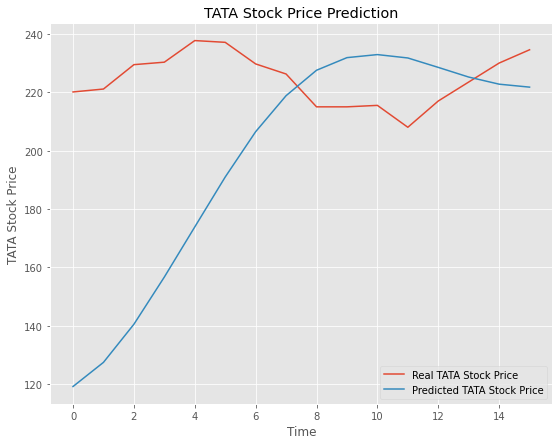

In [17]:
# Visualising the results
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
plt.plot(real_stock_price, label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

### Exercise

* Build a network with three or four $LSTM$ layers. How does this affect the performance?
* Change the size of the data window - how does a longer/shorter window affect the predictions?

<a id='multi_variate'></a>

## A more complex LSTM

This was a nice intro to using $LSTMs$. But in reality the input and output we want can be more complex. What happens if we have multiple factors that can affect our output, or what happens if we want to predict more than one step into the future? Luckily all of this is relatively straightforward to deal with. All we need to do is make sure that we can wrangle the datastructres correctly to fit the network.


### The Data

in this case we are going to look at air pollution. We will sped a bit of time working out how to treat the data. In the cell below wer deal with the fact that some of the data in the original frame is missing -- we fill in `na` values with zeros usign the convenient `pandas` function `fillna`. We also select to only look at certain columns of the data and also to drop the first 24 hours of data. Finally we save the treated data to `pollution_treated.csv` for reuse later. 

In [18]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(data_path + 'lstm-data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv(data_path + 'lstm-data/pollution_treated.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


#### Look at the data

Now we want to take a look at the data. We can load up the file we just created and plot the datasets.

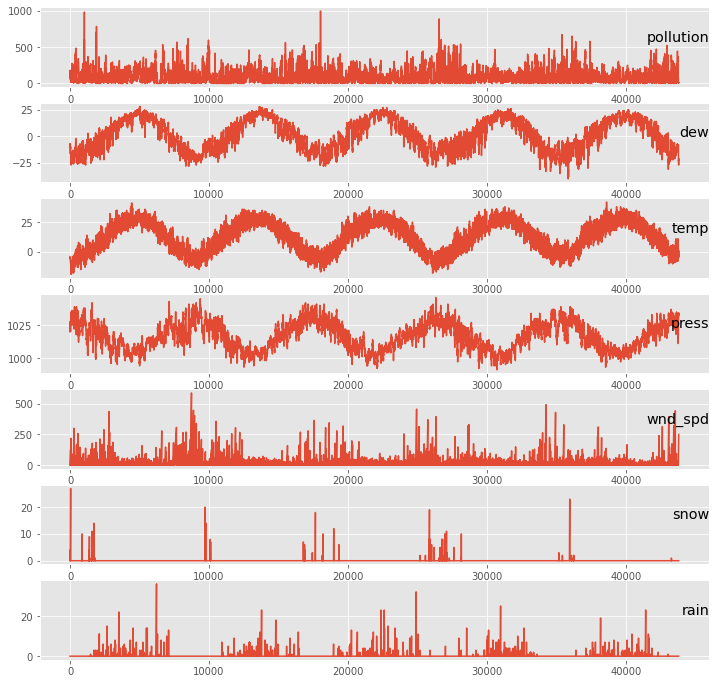

In [19]:
# load dataset
dataset = read_csv(data_path + 'lstm-data/pollution_treated.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(12, 12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

#### Encoding the data

We want to convert the data to formats work with our ML model. A notable case is wind direction `wnd_dir` - we will integer encode this using `scikit-learn`. You could also one-hot encode this if you want to.

Then we normalise the data using the `MinMaxScaler` as before.

In [20]:
from sklearn.preprocessing import LabelEncoder

# load dataset
dataset = read_csv(data_path + 'lstm-data/pollution_treated.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Converting to LSTM structure

In this case we want to look back just one step and predict forward just one step. How would you achieve this?

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
```
    
</p>
</details>

In [21]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t)  var8(t)  
1  0.003811  0.000000      0.0  
2  0.005332  0.000000      0.0  
3  0.008391

In our case we only want to predict the pollution in the future - this is `var1` so we do not require `var2, var3, etc` at time t. We can simply drop these from the dataframe:

In [22]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Split into training and test sets. 

In order to make this trianing run in a reasonable time we will take only the first year's worth of data as training data - this is $365*24$ hours of data. We then reshape the datasets so that they are in the shape expected for the $LSTM$ model.

In [23]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### Build the network

We now build the model $LSTM$ - we will build a simple model.

Can you adapt the code from [the build lstm section](#build_lstm) to make a single layer $LSTM$, with 50 units in the $LSTM$ and an `input_shape=(train_X.shape[1], train_X.shape[2])`?

If this is not working for you you can reveal the suggested answer below:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
```
    
</p>
</details>

In [24]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

### Compile and fit the network

As ever we have to now compile and train the model. We use the `adam` optimiser and mean absolute error as our loss function.

In [25]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    shuffle=False)

Epoch 1/50
122/122 [==============================] - 1s 6ms/step - loss: 0.0597 - val_loss: 0.0537
Epoch 2/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0525
Epoch 3/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0419
Epoch 4/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0362
Epoch 5/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0241
Epoch 6/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 7/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 8/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0154
Epoch 9/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 10/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0151

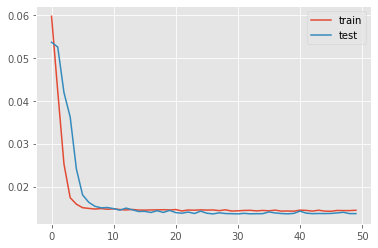

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.664


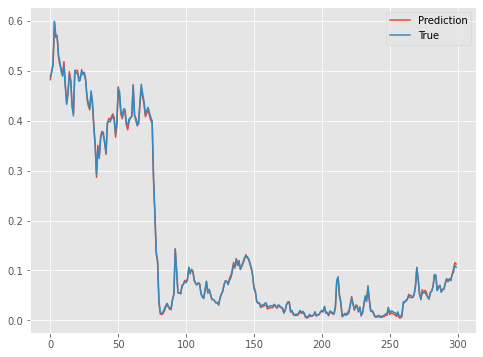

In [28]:
start_time = 1200
stop_time = 1500
plt.subplots(1, 1, figsize=(8, 6))
test_y.shape
plt.plot(yhat[start_time+1:stop_time+1, 0], label="Prediction")
plt.plot(test_y[start_time:stop_time, 0], label="True")
plt.legend()

### Exercise

Try using a longer time frame of previous steps for training the model - how does that affect performance?

In [29]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
print(reframed.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
3   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
4   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
5   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
6   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-2)  var8(t-2)  var1(t-1)  var2(t-1)  ...  var7(t-1)  var8(t-1)  \
2   0.000000        0.0   0.148893   0.367647  ...   0.000000        0.0   
3   0.000000        0.0   0.159960   0.426471  ...   0.000000        0.0   
4   0.000000        0.0   0.182093   0.485294  ...   0.037037        0.0   
5   0.037037        0.0   0.138833   0.485294  ...   0.074074        0.0   
6   0.074074        0.0   0.109658   0.485294  ...   0.111111        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
2  0.159960  0.426471  0.229508  0.545454

In [30]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
3   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
4   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
5   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
6   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-2)  var8(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  \
2   0.000000        0.0   0.148893   0.367647   0.245902   0.527273   
3   0.000000        0.0   0.159960   0.426471   0.229508   0.545454   
4   0.000000        0.0   0.182093   0.485294   0.229508   0.563637   
5   0.037037        0.0   0.138833   0.485294   0.229508   0.563637   
6   0.074074        0.0   0.109658   0.485294   0.213115   0.563637   

   var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)   var1(t)  
2   0.666667   0.003811   0.000000        0.0  0.159960  
3   0.666667   0.005332   0.00

In [31]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 16) (8760,) (35038, 1, 16) (35038,)


In [32]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

In [33]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    shuffle=False)

Epoch 1/50
122/122 [==============================] - 1s 6ms/step - loss: 0.0451 - val_loss: 0.0690
Epoch 2/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.0521
Epoch 3/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0184 - val_loss: 0.0297
Epoch 4/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0228
Epoch 5/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0170 - val_loss: 0.0207
Epoch 6/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0187
Epoch 7/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0181
Epoch 8/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 9/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 10/50
122/122 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0160